# 합성곱 신경망을 사용한 이미지 분류

## 패션 MNIST 데이터 불러오기

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()
    
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
    
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)    

## 합성곱 신경망 만들기

In [2]:
model = keras.Sequential()
model.add(keras.layers.Input(shape=(28,28,1)))
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'))

In [3]:
model.add(keras.layers.MaxPooling2D(2))

In [4]:
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))

In [5]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

In [6]:
model.summary() 
# param : 3x3(kernel_size)x이전깊이(입력채널수)x현재깊이(출력채널수)+현재깊이(바이어스)
# = (커널_높이×커널_너비×입력_채널)×출력_채널+출력_채널
# flatten (Flatten) 입력 크기: 7×7×64=3136

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

In [7]:
# https://graphviz.gitlab.io/download/ -> graphviz-2.50.0-win64.exe
!pip install pydot

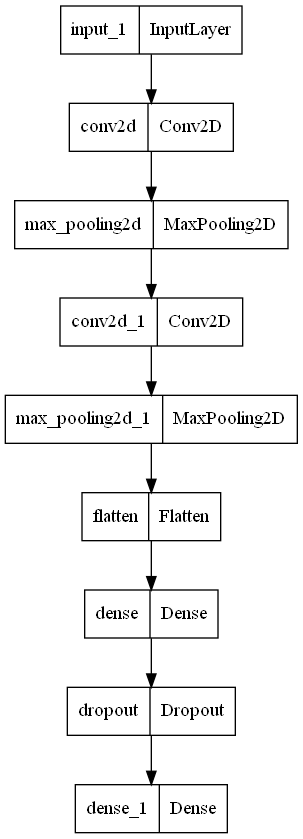

In [8]:
keras.utils.plot_model(model)

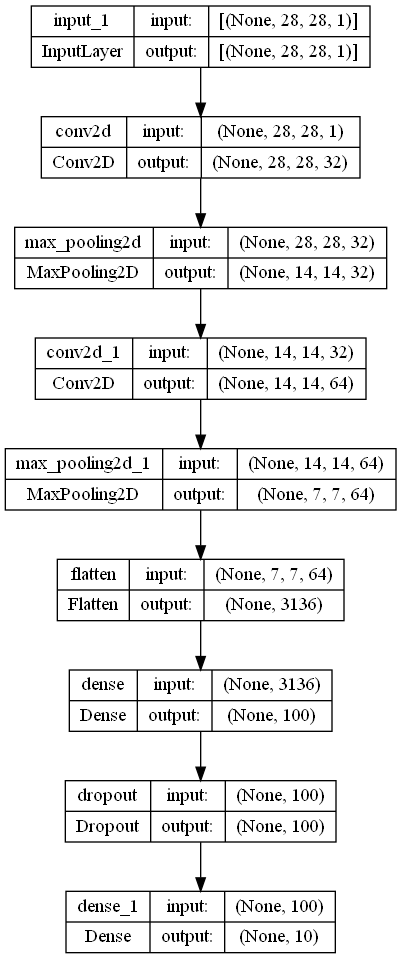

In [9]:
keras.utils.plot_model(model, show_shapes=True)

## 모델 컴파일과 훈련

In [10]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              # 현재 텐서플로 버전에서는 최대 풀링에 대한 결정적인 XLA 구현이 없기 때문에
              # enable_op_determinism() 호출로 인해 오류가 발생합니다.
              # 이를 피하기 위해 jit_compile 옵션을 False로 지정합니다.
              # https://github.com/tensorflow/tensorflow/issues/69417
              jit_compile=False)
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 19s 10ms/step - loss: 0.5405 - accuracy: 0.8052 - val_loss: 0.3309 - val_accuracy: 0.8794
Epoch 2/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.3583 - accuracy: 0.8712 - val_loss: 0.2817 - val_accuracy: 0.8931
Epoch 3/20
1500/1500 [==============================] - 14s 10ms/step - loss: 0.3078 - accuracy: 0.8883 - val_loss: 0.2625 - val_accuracy: 0.9011
Epoch 4/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.2680 - accuracy: 0.9033 - val_loss: 0.2428 - val_accuracy: 0.9087
Epoch 5/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.2437 - accuracy: 0.9125 - val_loss: 0.2423 - val_accuracy: 0.9107
Epoch 6/20
1500/1500 [==============================] - 14s 9ms/step - loss: 0.2257 - accuracy: 0.9172 - val_loss: 0.2305 - val_accuracy: 0.9183
Epoch 7/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.2056 - accuracy: 0.9234 - val_loss: 0.2209 - v

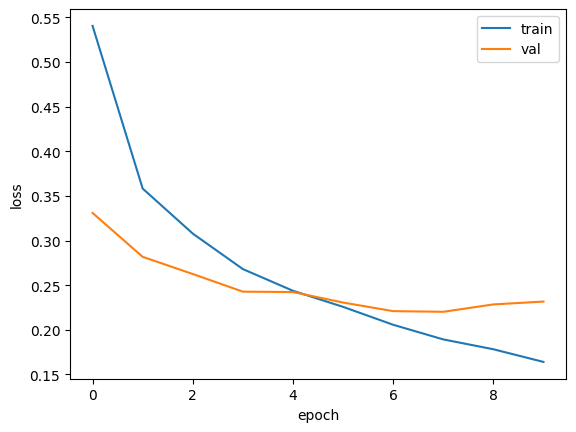

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [12]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.2202 - accuracy: 0.9210


[0.22018544375896454, 0.9210000038146973]

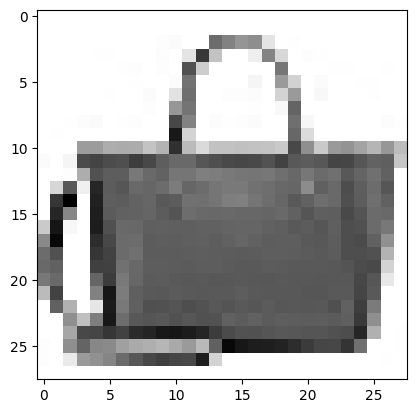

In [13]:
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

In [14]:
preds = model.predict(val_scaled[0:1])
print(preds)

1/1 [==============================] - 0s 400ms/step
[[6.5994687e-16 4.0688858e-24 3.2850643e-19 7.3835225e-18 2.5151469e-18
  4.0950464e-16 6.8161202e-19 3.5798346e-18 1.0000000e+00 2.4640935e-17]]


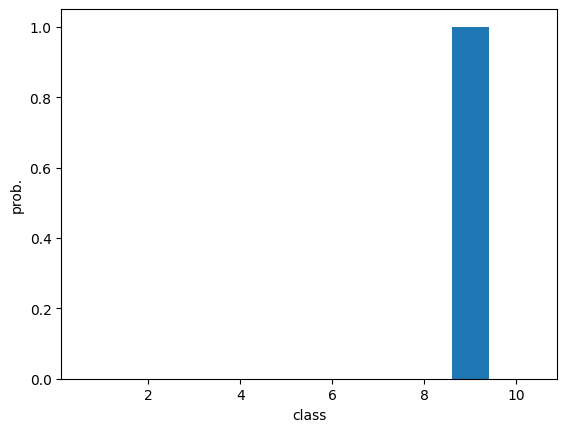

In [15]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [16]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트',
           '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [17]:
import numpy as np

print(classes[np.argmax(preds)])

가방


In [18]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 225.0

In [19]:
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 1s 4ms/step - loss: 0.2427 - accuracy: 0.9157


[0.24267245829105377, 0.9157000184059143]